# Chapter 14: Association Rules and Collaborative Filtering

> (c) 2019 Galit Shmueli, Peter C. Bruce, Peter Gedeck 
>
> Code included in
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition) 
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.

## Import required packages

In [1]:
# !pip uninstall scikit-surprise

In [2]:
# !pip install --upgrade surprise

In [3]:
# !py -m ensurepip --upgrade

In [4]:
# ! py -m pip install --upgrade pip

In [5]:
# !pip install mlxtend

In [6]:
# conda install -c conda-forge scikit-surprise

In [7]:
# !pip install dmba

In [8]:
from pathlib import Path

import heapq
from collections import defaultdict

import pandas as pd
import matplotlib.pylab as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split

import dmba

%matplotlib inline

## Table 14.4

In [9]:
# Load and preprocess data set 
fp_df = dmba.load_data('Faceplate.csv')
fp_df.set_index('Transaction', inplace=True)
fp_df

,Red,White,Blue,Orange,Green,Yellow
Transaction,,,,,,
1,1,1,0,0,1,0
2,0,1,0,1,0,0
3,0,1,1,0,0,0
4,1,1,0,1,0,0
5,1,0,1,0,0,0
6,0,1,1,0,0,0
7,1,0,1,0,0,0
8,1,1,1,0,1,0
9,1,1,1,0,0,0


In [10]:
# create frequent itemsets
itemsets = apriori(fp_df, min_support=0.2, use_colnames=True)

# and convert into rules
rules = association_rules(itemsets, metric='confidence', min_threshold=0.5)
rules.sort_values(by=['lift'], ascending=False).head(6)

print(rules.sort_values(by=['lift'], ascending=False)
      .drop(columns=['antecedent support', 'consequent support', 'conviction'])
      .head(6))

       antecedents   consequents  support  confidence      lift  leverage  \
13    (White, Red)       (Green)      0.2         0.5  2.500000      0.12   
15         (Green)  (White, Red)      0.2         1.0  2.500000      0.12   
4          (Green)         (Red)      0.2         1.0  1.666667      0.08   
12  (White, Green)         (Red)      0.2         1.0  1.666667      0.08   
7         (Orange)       (White)      0.2         1.0  1.428571      0.06   
8          (Green)       (White)      0.2         1.0  1.428571      0.06   

    zhangs_metric  
13          1.000  
15          0.750  
4           0.500  
12          0.500  
7           0.375  
8           0.375  


D:\Programs\anaconda\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [11]:
# filter to get rules with single consequents only
rules[[len(c) == 1 for c in rules.consequents]].sort_values(by=['lift'], ascending=False).head(6)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
13,"(White, Red)",(Green),0.4,0.2,0.2,0.5,2.500000,0.12,1.6,1.000
4,(Green),(Red),0.2,0.6,0.2,1.0,1.666667,0.08,inf,0.500
12,"(White, Green)",(Red),0.2,0.6,0.2,1.0,1.666667,0.08,inf,0.500
7,(Orange),(White),0.2,0.7,0.2,1.0,1.428571,0.06,inf,0.375
8,(Green),(White),0.2,0.7,0.2,1.0,1.428571,0.06,inf,0.375
14,"(Green, Red)",(White),0.2,0.7,0.2,1.0,1.428571,0.06,inf,0.375


The apriori method accepts sparse data frames as well. If we convert the original data frame to sparse format, we can see that the memory requirements go down to 40%. The `fill_value` argument informs the `to_sparse` method here which fields to ignore in each transaction.

In [12]:
# Convert data set into a sparse data frame
sparse_df = fp_df.astype(pd.SparseDtype(int, fill_value=0))
print('Density {}'.format(sparse_df.sparse.density))

# create frequent itemsets
itemsets = apriori(sparse_df, min_support=0.2, use_colnames=True)

# and convert into rules
rules = association_rules(itemsets, metric='confidence', min_threshold=0.5)
rules.sort_values(by=['lift'], ascending=False).head(6)

Density 0.4000000000000001


D:\Programs\anaconda\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
13,"(White, Red)",(Green),0.4,0.2,0.2,0.5,2.500000,0.12,1.6,1.000
15,(Green),"(White, Red)",0.2,0.4,0.2,1.0,2.500000,0.12,inf,0.750
4,(Green),(Red),0.2,0.6,0.2,1.0,1.666667,0.08,inf,0.500
12,"(White, Green)",(Red),0.2,0.6,0.2,1.0,1.666667,0.08,inf,0.500
7,(Orange),(White),0.2,0.7,0.2,1.0,1.428571,0.06,inf,0.375
8,(Green),(White),0.2,0.7,0.2,1.0,1.428571,0.06,inf,0.375


## Data required for Table 14.5 and 14.6

In [13]:
# Prepare the dataset for table 14.6 based on table 14.5
from itertools import chain
randomTransactions = [{8}, {3,4,8}, {8}, {3,9}, {9}, {1,8}, {6,9}, {3,5,7,9}, {8}, set(), 
                      {1,7,9}, {1,4,5,8,9}, {5,7,9}, {6,7,8}, {3,7,9}, {1,4,9}, {6,7,8}, {8}, set(), {9},
                      {2,5,6,8}, {4,6,9}, {4,9}, {8,9}, {6,8}, {1,6,8}, {5,8}, {4,8,9}, {9}, {8},
                      {1,5,8}, {3,6,9}, {7,9}, {7,8,9}, {3,4,6,8}, {1,4,8}, {4,7,8}, {8,9}, {4,5,7,9}, {2,8,9},
                      {2,5,9}, {1,2,7,9}, {5,8}, {1,7,8}, {8}, {2,7,9}, {4,6,9}, {9}, {9}, {6,7,8}]
print(randomTransactions)
uniqueItems = sorted(set(chain.from_iterable(randomTransactions)))
randomData = pd.DataFrame(0, index=range(len(randomTransactions)), columns=uniqueItems)
for row, transaction in enumerate(randomTransactions):
    for item in transaction:
        randomData.loc[row][item] = 1
randomData.head()

[{8}, {8, 3, 4}, {8}, {9, 3}, {9}, {8, 1}, {9, 6}, {9, 3, 5, 7}, {8}, set(), {1, 9, 7}, {1, 4, 5, 8, 9}, {9, 5, 7}, {8, 6, 7}, {9, 3, 7}, {1, 4, 9}, {8, 6, 7}, {8}, set(), {9}, {8, 2, 5, 6}, {9, 4, 6}, {9, 4}, {8, 9}, {8, 6}, {8, 1, 6}, {8, 5}, {8, 9, 4}, {9}, {8}, {8, 1, 5}, {9, 3, 6}, {9, 7}, {8, 9, 7}, {8, 3, 4, 6}, {8, 1, 4}, {8, 4, 7}, {8, 9}, {9, 4, 5, 7}, {8, 9, 2}, {9, 2, 5}, {1, 2, 9, 7}, {8, 5}, {8, 1, 7}, {8}, {9, 2, 7}, {9, 4, 6}, {9}, {9}, {8, 6, 7}]


,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,0,1,0
1,0,0,1,1,0,0,0,1,0
2,0,0,0,0,0,0,0,1,0
3,0,0,1,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,1


## Table 14.6

In [14]:
# create frequent itemsets
itemsets = apriori(randomData, min_support=2/len(randomData), use_colnames=True)
# and convert into rules
rules = association_rules(itemsets, metric='confidence', min_threshold=0.7)
print(rules.sort_values(by=['lift'], ascending=False)
      .drop(columns=['antecedent support', 'consequent support', 'conviction'])
      .head(6))

  antecedents consequents  support  confidence      lift  leverage  \
3      (8, 3)         (4)     0.04         1.0  4.545455    0.0312   
1      (1, 5)         (8)     0.04         1.0  1.851852    0.0184   
2      (2, 7)         (9)     0.04         1.0  1.851852    0.0184   
4      (3, 4)         (8)     0.04         1.0  1.851852    0.0184   
5      (3, 7)         (9)     0.04         1.0  1.851852    0.0184   
6      (4, 5)         (9)     0.04         1.0  1.851852    0.0184   

   zhangs_metric  
3       0.812500  
1       0.479167  
2       0.479167  
4       0.479167  
5       0.479167  
6       0.479167  


D:\Programs\anaconda\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


## Table 14.8

In [15]:
# load dataset
all_books_df = dmba.load_data('CharlesBookClub.csv')

# create the binary incidence matrix
ignore = ['Seq#', 'ID#', 'Gender', 'M', 'R', 'F', 'FirstPurch', 'Related Purchase',
          'Mcode', 'Rcode', 'Fcode', 'Yes_Florence', 'No_Florence']
count_books = all_books_df.drop(columns=ignore)
count_books[count_books > 0] = 1

count_books.head()

,ChildBks,YouthBks,CookBks,DoItYBks,RefBks,ArtBks,GeogBks,ItalCook,ItalAtlas,ItalArt,Florence
0,0,1,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,1,0,1,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0


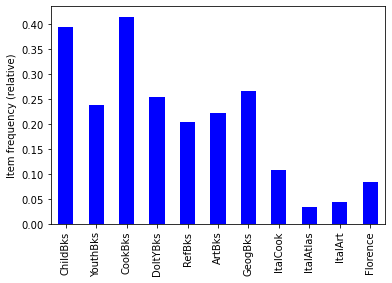

In [16]:
# determine item frequencies
itemFrequency = count_books.sum(axis=0) / len(count_books)

# and plot as histogram
ax = itemFrequency.plot.bar(color='blue')
plt.ylabel('Item frequency (relative)')
plt.show()

In [17]:
# create frequent itemsets and rules
itemsets = apriori(count_books, min_support=200/4000, use_colnames=True)
rules = association_rules(itemsets, metric='confidence', min_threshold=0.5)

print('Number of rules', len(rules))

# Display 25 rules with highest lift
rules.sort_values(by=['lift'], ascending=False).head(25)

pd.set_option('precision', 5)
pd.set_option('display.width', 100)
print(rules.sort_values(by=['lift'], ascending=False).drop(columns=['antecedent support', 'consequent support', 'conviction']).head(25))
pd.set_option('precision', 6)

D:\Programs\anaconda\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Number of rules 81


OptionError: 'Pattern matched multiple keys'

In [ ]:
# Filter rules by number of antecedents (maximum 2) and consequents (maximum 1)
rules = rules[[len(c) <= 2 for c in rules.antecedents]]
rules = rules[[len(c) == 1 for c in rules.consequents]]

rules.sort_values(by=['lift'], ascending=False).head(10)

## Section 14.2 Collaborative Filtering

In [ ]:
ratings = pd.DataFrame([
    [30878, 1, 4], [30878, 5, 1], [30878, 18, 3], [30878, 28, 3], [30878, 30, 4], [30878, 44, 5], 
    [124105, 1, 4], 
    [822109, 1, 5], 
    [823519, 1, 3], [823519, 8, 1], [823519, 17, 4], [823519, 28, 4], [823519, 30, 5], 
    [885013, 1, 4], [885013, 5, 5], 
    [893988, 1, 3], [893988, 30, 4], [893988, 44, 4], 
    [1248029, 1, 3], [1248029, 28, 2], [1248029, 30, 4], [1248029, 48, 3], 
    [1503895, 1, 4], 
    [1842128, 1, 4], [1842128, 30, 3], 
    [2238063, 1, 3], 
], columns=['customerID', 'movieID', 'rating'])

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['customerID', 'movieID', 'rating']], reader)
trainset = data.build_full_trainset()
sim_options = {'name': 'cosine', 'user_based': False}  # compute cosine similarities between items
algo = KNNBasic(sim_options=sim_options)
algo.fit(trainset)
pred = algo.predict(str(823519), str(30), r_ui=4, verbose=True)

## Table 14.11

In [ ]:
import random

random.seed(0)
nratings = 5000
randomData = pd.DataFrame({
    'itemID': [random.randint(0,99) for _ in range(nratings)],
    'userID': [random.randint(0,999) for _ in range(nratings)],
    'rating': [random.randint(1,5) for _ in range(nratings)],
})

def get_top_n(predictions, n=10):
    # First map the predictions to each user.
    byUser = defaultdict(list)
    for p in predictions:
        byUser[p.uid].append(p)
    
    # For each user, reduce predictions to top-n
    for uid, userPredictions in byUser.items():
        byUser[uid] = heapq.nlargest(n, userPredictions, key=lambda p: p.est)
    return byUser

# Convert thes data set into the format required by the surprise package
# The columns must correspond to user id, item id and ratings (in that order)
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(randomData[['userID', 'itemID', 'rating']], reader)

# Split into training and test set
trainset, testset = train_test_split(data, test_size=.25, random_state=1)

## User-based filtering
# compute cosine similarity between users 
sim_options = {'name': 'cosine', 'user_based': True}
algo = KNNBasic(sim_options=sim_options)
algo.fit(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
predictions = algo.test(testset)

top_n = get_top_n(predictions, n=4)

# Print the recommended items for each user
print()
print('Top-4 recommended items for each user')
for uid, user_ratings in list(top_n.items())[:5]:
    print('User {}'.format(uid))
    for prediction in user_ratings:
        print('  Item {0.iid} ({0.est:.2f})'.format(prediction), end='')
    print()
print()

    
## Item-based filtering
# compute cosine similarity between users 
sim_options = {'name': 'cosine', 'user_based': False}
algo = KNNBasic(sim_options=sim_options)
algo.fit(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
predictions = algo.test(testset)
top_n = get_top_n(predictions, n=4)

# Print the recommended items for each user
print()
print('Top-4 recommended items for each user')
for uid, user_ratings in list(top_n.items())[:5]:
    print('User {}'.format(uid))
    for prediction in user_ratings:
        print('  Item {0.iid} ({0.est:.2f})'.format(prediction), end='')
    print()

In [ ]:
## Build a model using the full dataset
trainset = data.build_full_trainset()
sim_options = {'name': 'cosine', 'user_based': False}
algo = KNNBasic(sim_options=sim_options)
algo.fit(trainset)

# Predict rating for user 383 and item 7
algo.predict(383, 7)